In [1]:
# imports
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read all words
words = open('names.txt').read().splitlines()
words[:7]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia']

In [3]:
len(words)

32033

In [4]:
# build vocabulary of charactars and mapping to/from integers(indexes)
chars = sorted(set(''.join(words)))
stoi = {s:i+1 for i, s in enumerate(chars)} # map from charactors to integers
stoi['.'] = 0 # '.' will be a special character indicating word end

itos = {i:s for s, i in stoi.items()} # map from integers to characters
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the datset
batch_size = 3 # character context size: how many characters it takes to predict the next character

X, Y = [], []
for w in words:
    
    # print(w)
    context = [0] * batch_size
    for c in w + '.':
        idx = stoi[c]
        X.append(context)
        Y.append(idx)
        # print(''.join(itos[i] for i in context), '---->', c)
        context = context[1:] + [idx]

X = torch.tensor(X)
Y = torch.tensor(Y)
        

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [7]:
C = torch.randn((27, 2)) # our embedding matrix: represent all 27 characters into 2-dimensional space

In [8]:
emb = C[X] # input embeddings
emb.shape

torch.Size([228146, 3, 2])

In [9]:
W1 = torch.randn((6, 100)) # first layer of weights and biases
b1 = torch.randn(100)

In [10]:
h = torch.tanh(emb.view((-1, 6)) @ W1 + b1) # combining the embedding vectors for each previous character into a single vector
h

tensor([[ 0.4843,  0.3921,  0.0321,  ...,  0.0091, -0.6719, -0.6490],
        [ 0.7270,  0.6158,  0.0216,  ...,  0.0687, -0.9624, -0.1872],
        [ 0.2245, -0.1061, -0.7698,  ...,  0.9690,  0.9435, -0.4779],
        ...,
        [ 0.5037,  0.9987, -0.4474,  ..., -0.9991, -0.9992, -0.8569],
        [-0.2407,  0.9977, -0.9914,  ..., -0.8586,  0.6278, -0.9866],
        [-0.8057,  0.7584,  0.9877,  ..., -0.9997, -0.8174, -0.9996]])

In [11]:
h.shape

torch.Size([228146, 100])

In [12]:
W2 = torch.randn((100, 27)) # output layer: a vector representing all the possible 27 next characters
b2 = torch.randn(27)

In [13]:
logits = h @ W2 + b2

In [14]:
logits.shape

torch.Size([228146, 27])

In [15]:
counts = logits.exp()

In [16]:
probs = counts / counts.sum(1, keepdims=True) # make a probability distribution
probs

tensor([[2.6105e-07, 1.0027e-16, 6.4176e-11,  ..., 5.1319e-09, 2.2159e-05,
         1.0522e-04],
        [4.3495e-05, 1.1859e-16, 2.1035e-09,  ..., 6.4457e-08, 2.7817e-06,
         7.2749e-05],
        [2.9456e-08, 1.6276e-14, 2.6064e-10,  ..., 5.8808e-09, 1.4014e-01,
         1.2946e-01],
        ...,
        [9.0579e-08, 2.9014e-13, 5.6117e-06,  ..., 1.6473e-03, 1.9170e-06,
         1.6814e-08],
        [2.6495e-14, 3.7616e-20, 7.0533e-13,  ..., 1.1315e-13, 9.8546e-01,
         1.5922e-10],
        [9.7671e-11, 3.3264e-12, 3.5519e-08,  ..., 1.1095e-09, 9.8285e-12,
         8.3744e-11]])

In [17]:
loss = -probs[torch.arange(X.shape[0]), Y].log().mean() # loss: average negative log likelihood loss for the correct labels only
loss

tensor(18.0217)

In [18]:
# we can use cross-entropy function in pytorch combine log-likelihood steps into one step

# counts = logits.exp()
# probs = counts / counts.sum(1, keepdims=True) 
# loss = -probs[torch.arange(X.shape[0]), Y].log().mean() 
loss = F.cross_entropy(logits, Y) # it is faster, and numerically save(handle well large exponents that could reach inf.)
loss

tensor(18.0217)

In [19]:
# --- organized our work :), ready for training ---

In [39]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [82]:
# initialize the neural network pa
C = torch.randn((27, 2))
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

parameters = [C, W1, b1, W2, b2]

In [83]:
print("total number of parameters:", sum(p.nelement() for p in parameters))

total number of parameters: 3481


In [84]:
for p in parameters: # reset the gradients
    p.requires_grad = True

In [85]:
# make a function to use later
def initialize_network():
    C = torch.randn((27, 2))
    W1 = torch.randn((6, 100))
    b1 = torch.randn(100)
    W2 = torch.randn((100, 27))
    b2 = torch.randn(27)
    
    parameters = [C, W1, b1, W2, b2]

    for p in parameters: # reset the gradients
        p.requires_grad = True

In [86]:
# training the full data set
for i in range(100):
    # forward pass
    emb = C[X]
    h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad=None
    loss.backward()

    # update
    for p in parameters:
        p.data += -0.1 * p.grad
        
# print(loss.item())

18.426721572875977
16.81965446472168
15.609461784362793
14.546439170837402
13.684614181518555
13.110270500183105
12.721434593200684
12.754218101501465
11.748623847961426
11.135844230651855
10.736065864562988
10.341464042663574
10.036140441894531
9.497637748718262
9.150259017944336
8.790803909301758
8.503925323486328
8.187623023986816
7.946229457855225
7.675705432891846
7.4719696044921875
7.224559783935547
7.058150768280029
6.8199076652526855
6.686949729919434
6.458673000335693
6.3548479080200195
6.1442413330078125
6.065235137939453
5.869753360748291
5.806467056274414
5.627385139465332
5.572943210601807
5.412596702575684
5.363518238067627
5.221881866455078
5.175706386566162
5.051942825317383
5.006772518157959
4.898983001708984
4.853638648986816
4.759729862213135
4.713759899139404
4.6317458152771
4.584976673126221
4.513268947601318
4.4662275314331055
4.403817176818848
4.357509613037109
4.303915023803711
4.259396076202393
4.21376895904541
4.171821117401123
4.1332173347473145
4.09410238265

In [91]:
# that's alot of time for just 100 iterations; since we are taking all 228146 examples at once!
# next is to divide the training set into random batches for training

initialize_network()

for i in range(100):
    # take a mini-batch
    batch_size = 32
    batch_idxs = torch.randint(0, X.shape[0], (batch_size, ))
    X_batch = X[batch_idxs]
    Y_batch = Y[batch_idxs]
    
    # forward pass
    emb = C[X_batch]
    h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_batch)
    print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad=None
    loss.backward()

    for p in parameters:
        p.data += -0.1 * p.grad

    
# print(loss.item())

3.8107967376708984
2.7966599464416504
3.0431041717529297
3.012333631515503
3.091721773147583
3.2076873779296875
3.2112953662872314
2.9657156467437744
2.8400588035583496
3.5347228050231934
3.0516116619110107
2.836212635040283
3.169888734817505
3.2275328636169434
3.044888734817505
3.8744142055511475
2.997924327850342
2.72920823097229
3.6521694660186768
3.03806209564209
3.18325138092041
3.046625852584839
3.1046299934387207
3.0213146209716797
2.898686647415161
3.1912763118743896
3.1621406078338623
2.871431350708008
3.1278131008148193
3.565725564956665
2.9411797523498535
2.894089937210083
3.022932529449463
2.887626886367798
2.832122564315796
2.917869806289673
2.986151695251465
2.8361494541168213
2.931771755218506
2.922860860824585
3.0808768272399902
2.9371085166931152
2.9686315059661865
3.274595260620117
2.6723008155822754
3.064596176147461
2.807950735092163
2.9485254287719727
2.9015719890594482
3.0357236862182617
2.9395556449890137
2.780923366546631
2.6693544387817383
3.2382709980010986
2.

In [92]:
# that's alot faster :D, picking a good learning rate is next!

# our approach is it to manually look for:
# 1. a relatively high learning rate wheres the losses explode, or fluctuate alot
# 2. a relatively low learning rate wheres our optimization is not doing anything
# 3. after that we take the best learning rate in that range
# we get a range of [1.0, 0.001] learning rate; or we can say a range[-3, 0] learning rate exponents

In [93]:
lre = torch.linspace(-3, 0, 1000) # a range of 1000 exponent between -3, 0
lrs = 10**lre # the actual learning rates
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [96]:
initialize_network()

# train with different learning rates

lri = []
lossi = []
for i in range(1000):
    # mini-batch
    batch_idxs = torch.randint(0, X.shape[0], (32, ))
    X_batch = X[batch_idxs]
    Y_batch = Y[batch_idxs]
    
    # forward pass
    emb = C[X_batch]
    h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_batch)
    # print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad=None
    loss.backward()

    # update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    lri.append(lre[i])
    lossi.append(loss.item())

    
# print(loss.item())

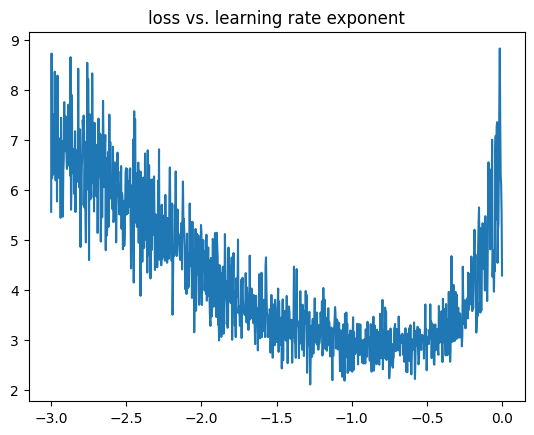

In [97]:
plt.plot(lri, lossi)
plt.title('loss vs. learning rate exponent');

In [30]:
# we see that the best learning rate lies where the exponent equals -1.0 (i.e. learning rate of 0.1; 10**-1 = 0.1)

In [31]:
# ---- now our hyperparameters is optimized, let's combine what we did so far ----

In [32]:
# initialization
C = torch.randn((27, 2))
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

parameters = [C, W1, b1, W2, b2]

print("total number of parameters:", sum(p.nelement() for p in parameters))
for p in parameters: # reset the gradients
    p.requires_grad = True

total number of parameters: 3481


In [33]:
# training
# lri = []
# lossi = []
for i in range(10000):
    # mini-batch
    batch_idxs = torch.randint(0, X.shape[0], (32, ))
    X_batch = X[batch_idxs]
    Y_batch = Y[batch_idxs]
    
    # forward pass
    emb = C[X_batch]
    h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_batch)
    # print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad=None
    loss.backward()

    # update
    # lr = lrs[i]
    lr = 0.1 # best learning rate
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())

    
print(loss.item()) # training loss

2.4858617782592773


In [34]:
# loss for all datasets
emb = C[X]
h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y) # cross-entropy: exp(logits)/sum(exp(logits)) aummarized into one step, faster.
loss

tensor(2.4306, grad_fn=<NllLossBackward0>)